In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from preprocess import Audio_Processor
import classifiers
import feature_reduce
import time
import data_utils as du
from sklearn import metrics
import snn_classifier as snn_clas

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [3]:
path_to_db='../ESC-50/'
preprocess = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [4]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['animal', 'nature', 'human', 'domestic', 'urban']

In [5]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    if target < 10:
        dataset.loc[index, 'h_category'] = 0
    elif target < 20:
        dataset.loc[index, 'h_category'] = 1
    elif target < 30:
        dataset.loc[index, 'h_category'] = 2
    elif target < 40:
        dataset.loc[index, 'h_category'] = 3
    elif target < 50:
        dataset.loc[index, 'h_category'] = 4

In [6]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,1
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,3
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,3
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


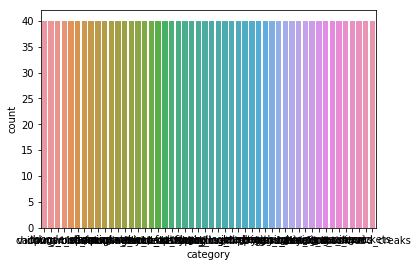

In [7]:
sns.countplot(dataset['category'])

## Preprocessing
Just MFCC were sufficient in previous work.
13 coefficients together with first and second derivatives and remove first energy component.
Should yield vector of 38 features per time frame.

In [8]:
test_file = pd.DataFrame(preprocess.preprocess('2-102414-A-17.wav'))

In [9]:
test_file.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,25.411559,23.449465,20.972643,18.525894,16.212746,13.842392,11.292716,8.694395,6.294877,4.214127,...,0.000662,0.000516,0.000268,0.000141,0.000195,0.000287,0.000253,0.000102,-0.000003,0.000068
1,25.411725,23.449751,20.972978,18.526156,16.212884,13.842465,11.292816,8.694541,6.295007,4.214183,...,0.000662,0.000516,0.000268,0.000141,0.000195,0.000287,0.000253,0.000102,-0.000003,0.000068
2,25.412225,23.450609,20.973984,18.526941,16.213296,13.842686,11.293117,8.694980,6.295397,4.214349,...,0.000662,0.000516,0.000268,0.000141,0.000195,0.000287,0.000253,0.000102,-0.000003,0.000068
3,25.413056,23.452037,20.975658,18.528247,16.213980,13.843050,11.293617,8.695711,6.296046,4.214625,...,0.000662,0.000516,0.000268,0.000141,0.000195,0.000287,0.000253,0.000102,-0.000003,0.000068
4,25.414214,23.454029,20.977996,18.530071,16.214934,13.843558,11.294315,8.696732,6.296953,4.215008,...,0.000662,0.000516,0.000268,0.000141,0.000195,0.000287,0.000253,0.000102,-0.000003,0.000068


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
import pickle
def save_obj(obj, name ):
    with open('../preprocessed_objs/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('../preprocessed_objs/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def process_fold(fld):
    try:
        df = load_obj("fold_" + str(fld))
    except IOError:
        start_time = time.time()
        df = preprocess.preprocess_fold(fld, dataset, parallel=False)
        print("\tBytes: " + str(df.memory_usage(index=True).sum()))
        print("\tProcessing Time: " + str(time.time() - start_time))
        save_obj(df, "fold_" + str(fld))
    return df

In [11]:
c_data = pd.concat([process_fold(fld) for fld in range(1,6)], ignore_index=True)

In [12]:
c_data.head()

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,...,MFCCp2_4,MFCCp2_5,MFCCp2_6,MFCCp2_7,MFCCp2_8,MFCCp2_9,MFCCp2_10,MFCCp2_11,MFCCp2_12,target
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0
1,83.621621,-50.483010,-31.115186,-3.566867,-19.398316,-14.354486,-4.658161,-14.146847,-16.949019,-1.723476,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0
2,109.848331,-110.083820,-54.568920,-30.153585,-58.985460,-5.598281,-5.862913,17.490401,12.544187,13.053928,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0
3,77.698670,-123.925469,-64.058169,-27.170063,-57.606930,-9.980594,6.718248,21.293678,15.173490,-1.113725,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0
4,58.790968,-133.719666,-76.282456,-25.140746,-54.371150,-13.053846,14.737484,17.361937,12.619366,-8.285872,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0


In [13]:
n_categories = c_data.target.unique().size

In [14]:
c_data, scalar = du.normalize_data(c_data, 'target')
train, test = du.split_training_test(c_data, 0.2)
train_X = train.drop(columns=['target'])
train_y = train.target
test_X = test.drop(columns=['target'])
test_y = test.target

# Some statistics
We have a lot of negatives when compared to positives when training shallow nets, if improving accuracy it will naturally gravitate toward guessing 0

## Distribution of MFCCs
Distribution for all 50 classes

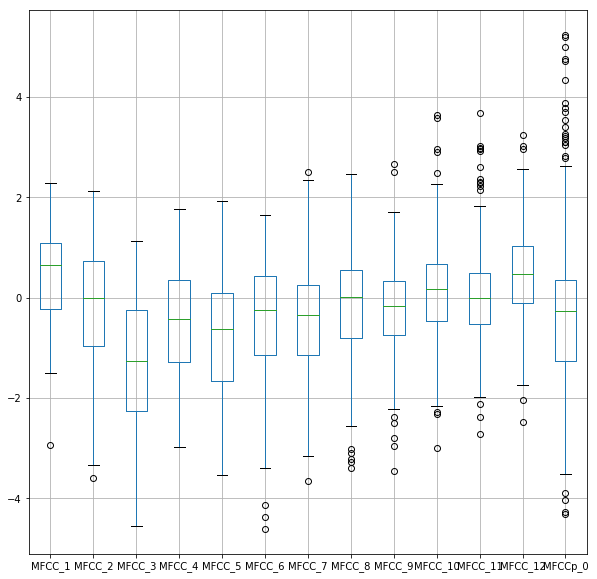

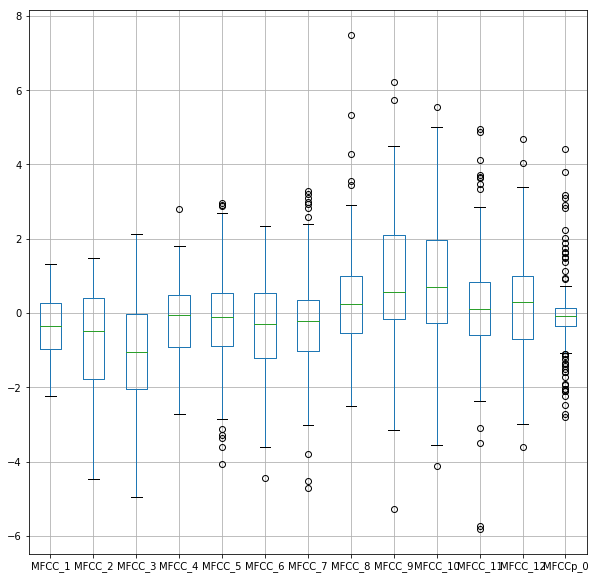

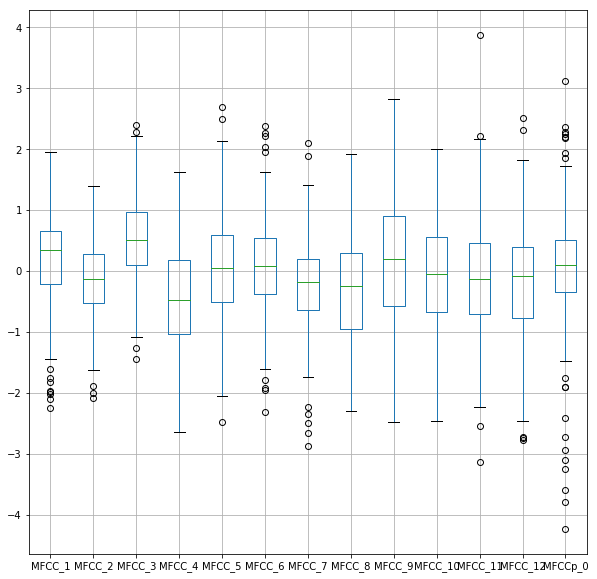

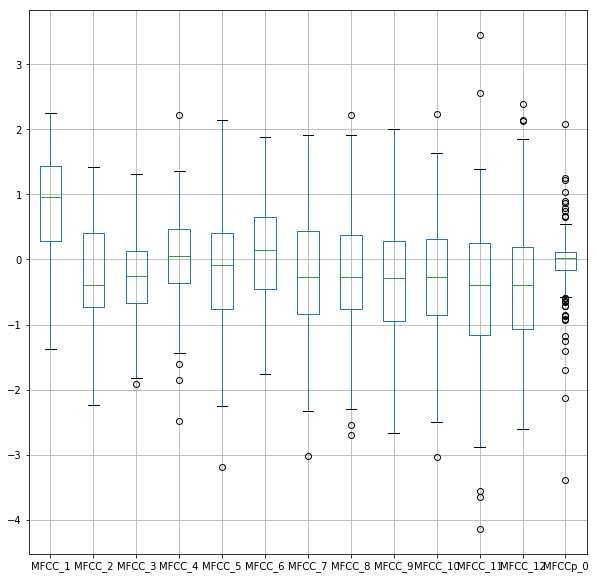

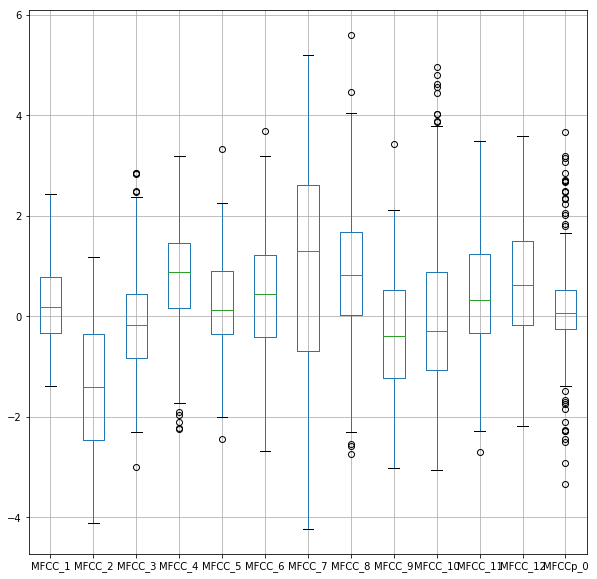

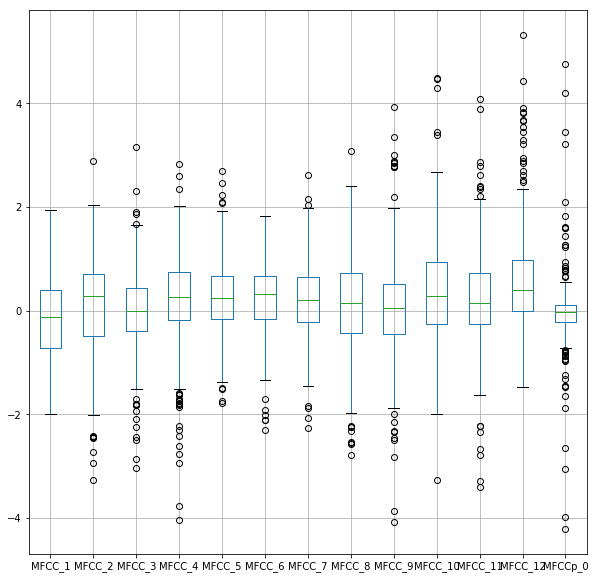

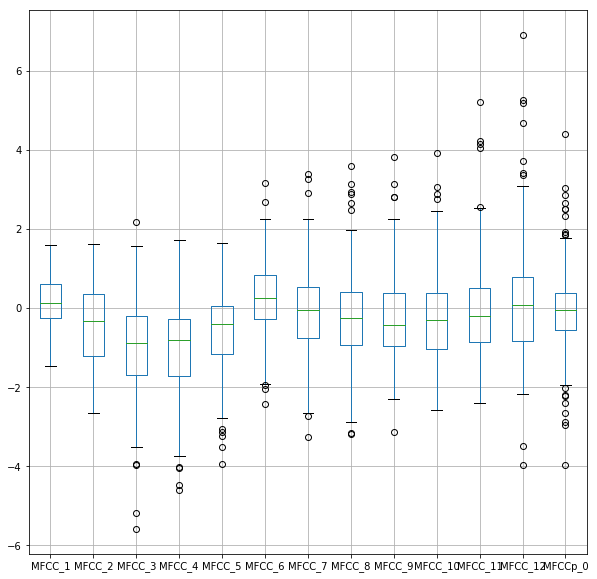

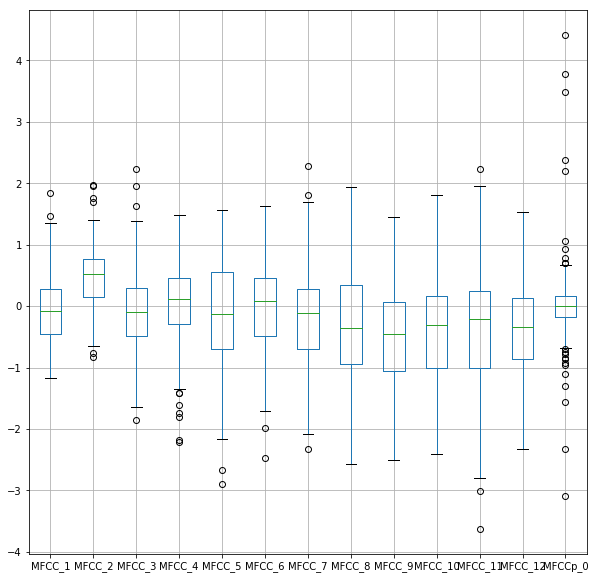

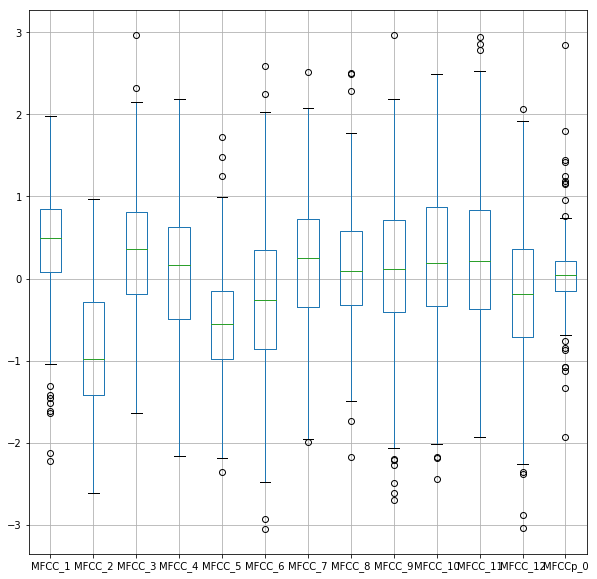

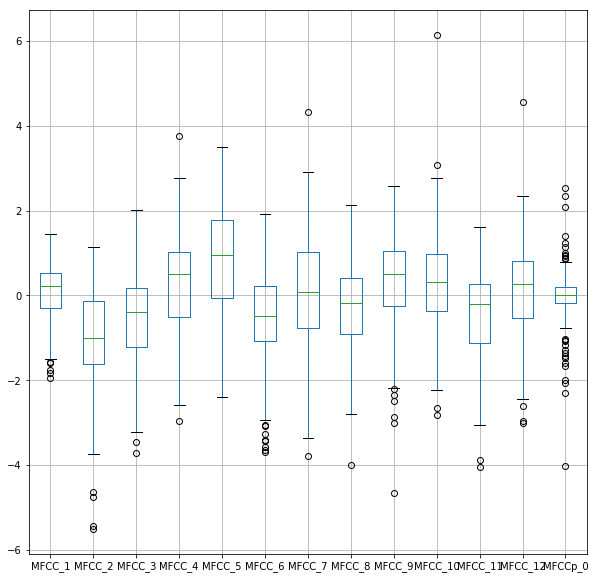

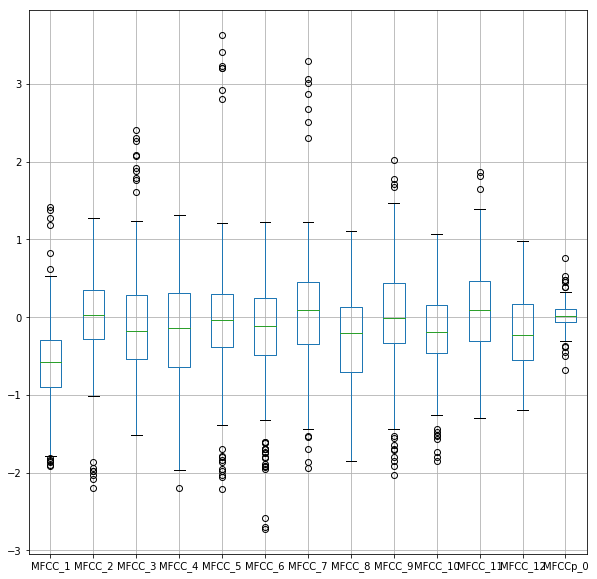

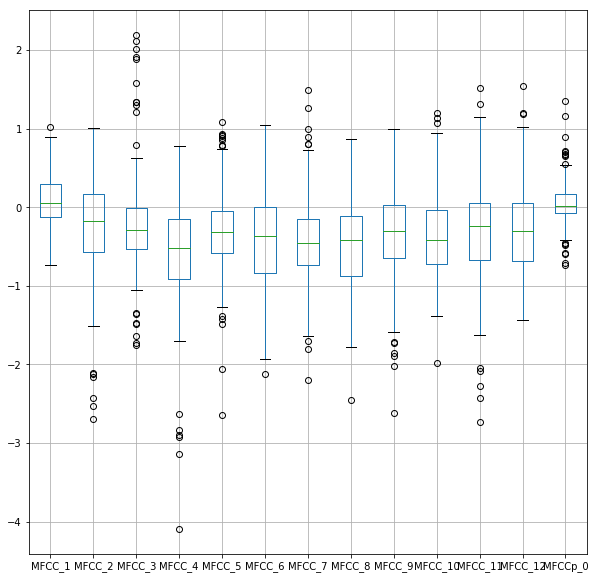

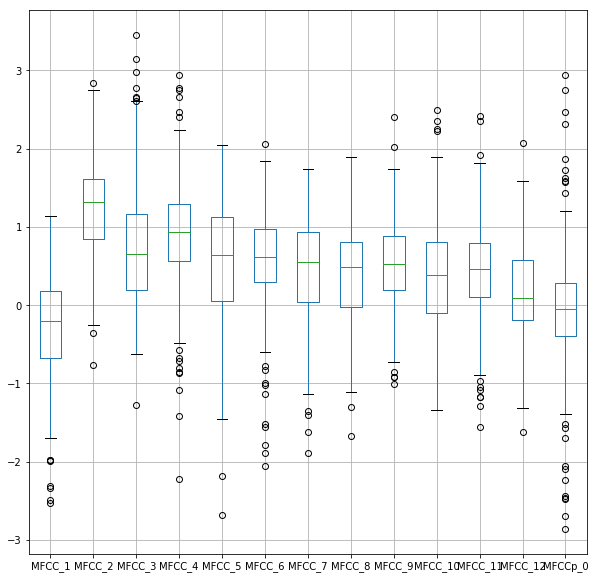

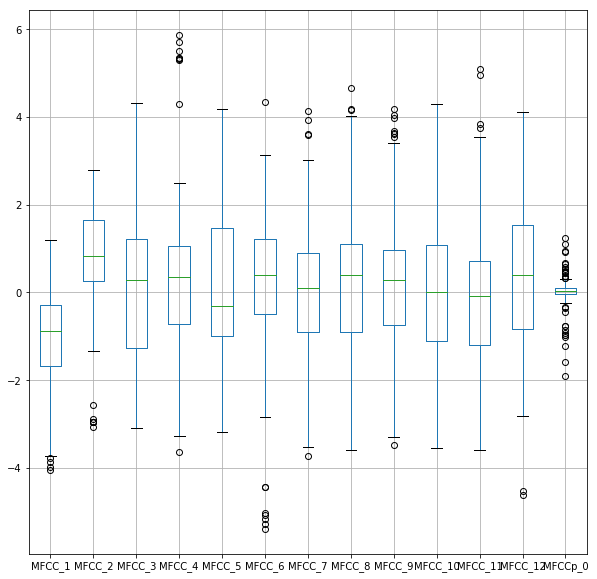

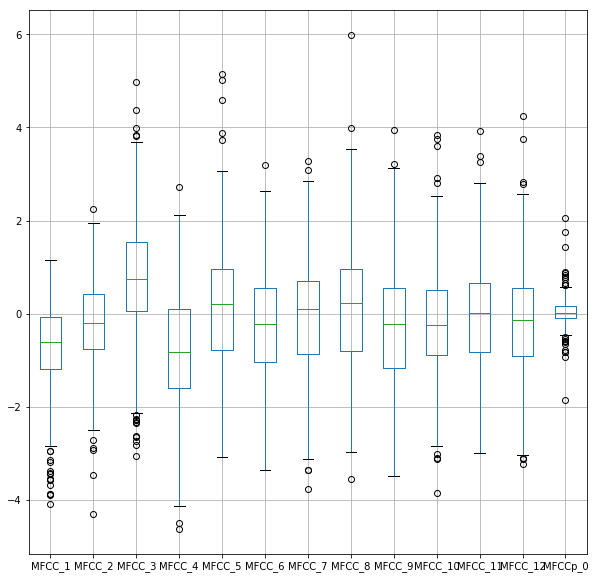

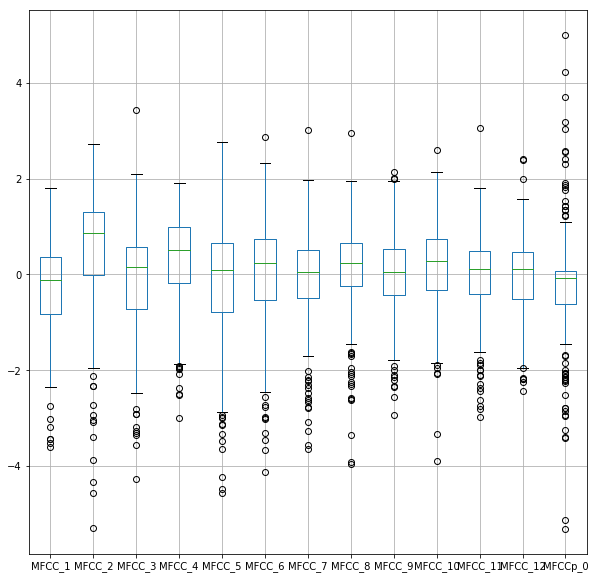

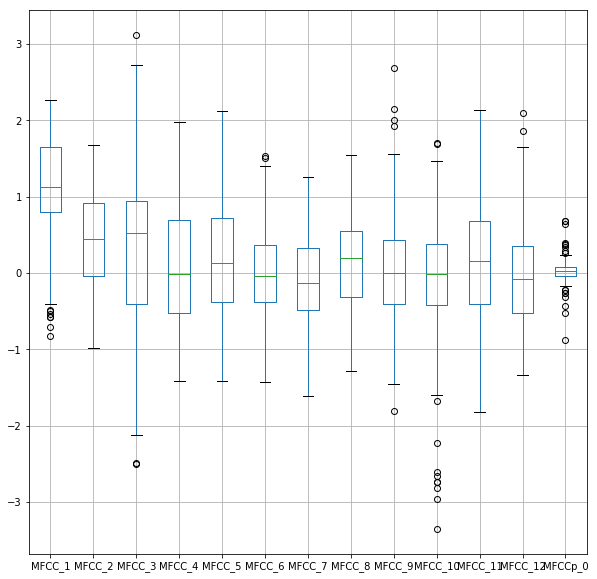

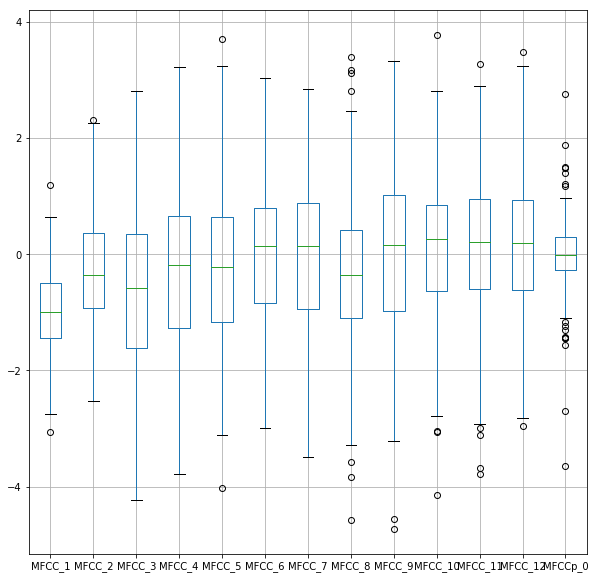

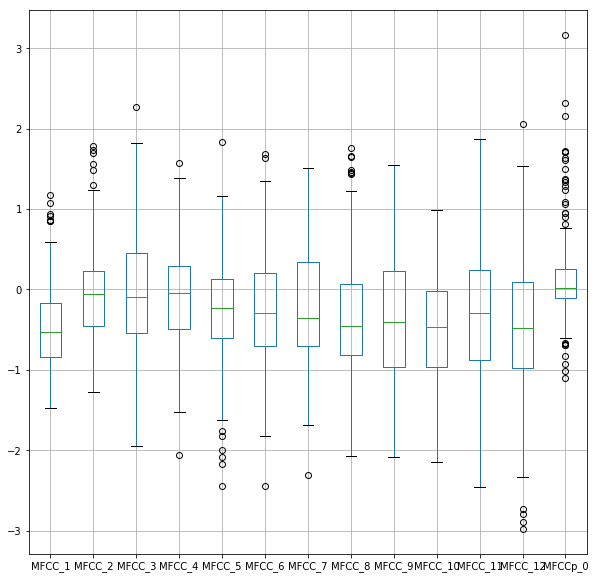

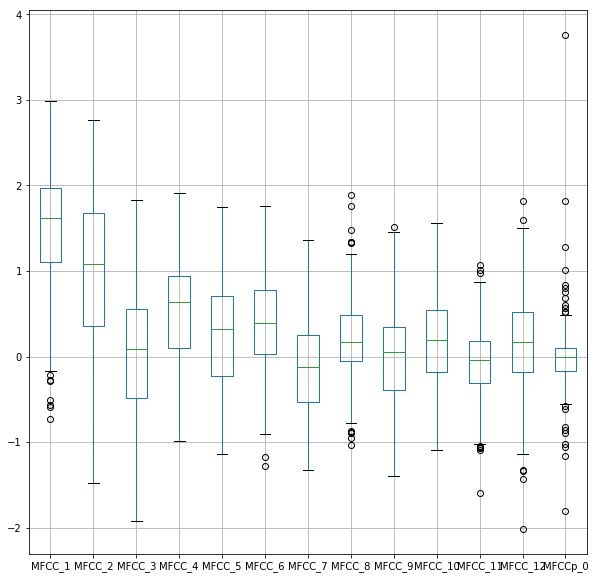

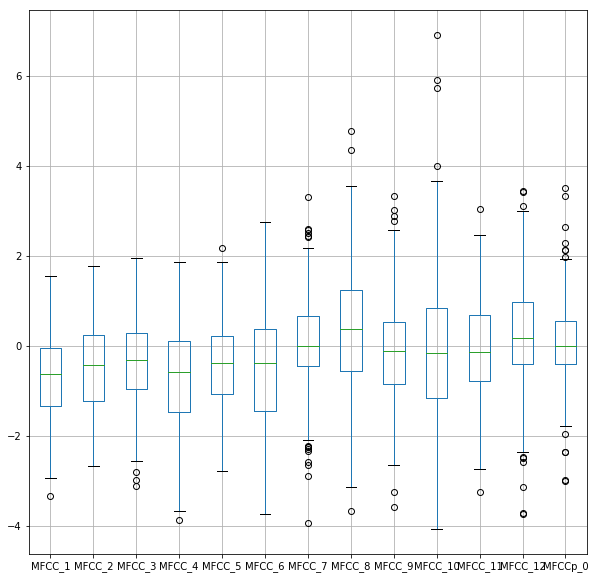

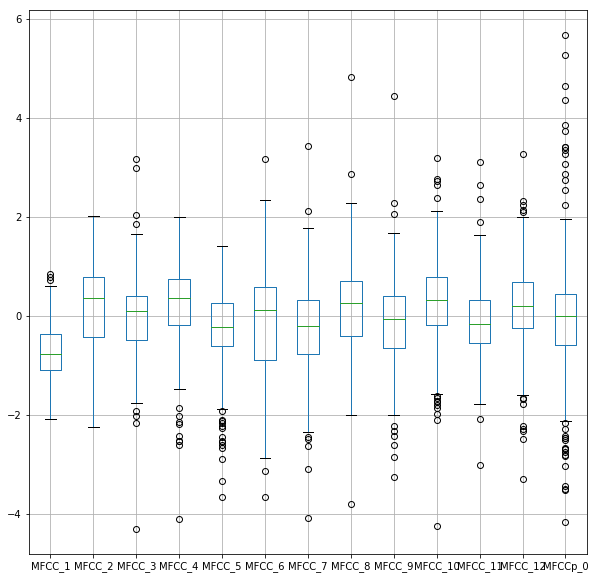

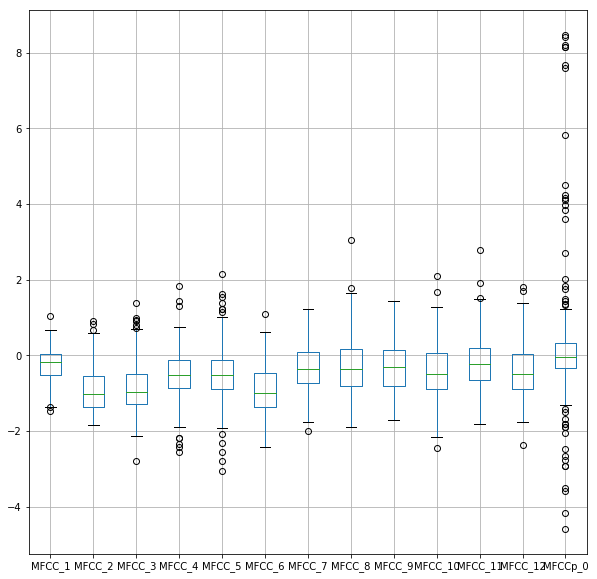

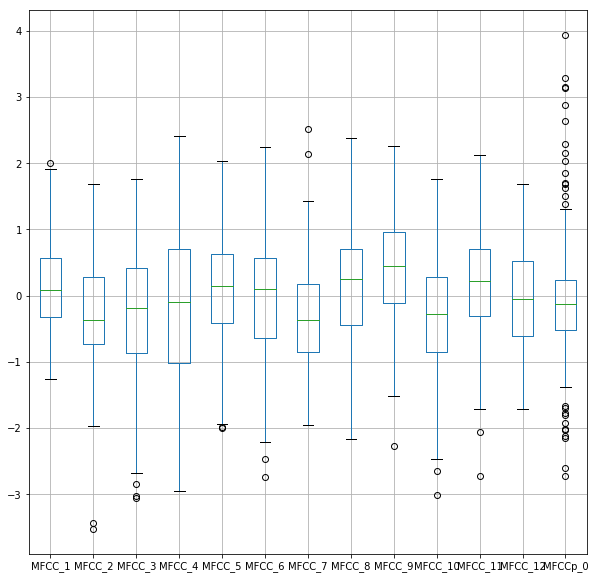

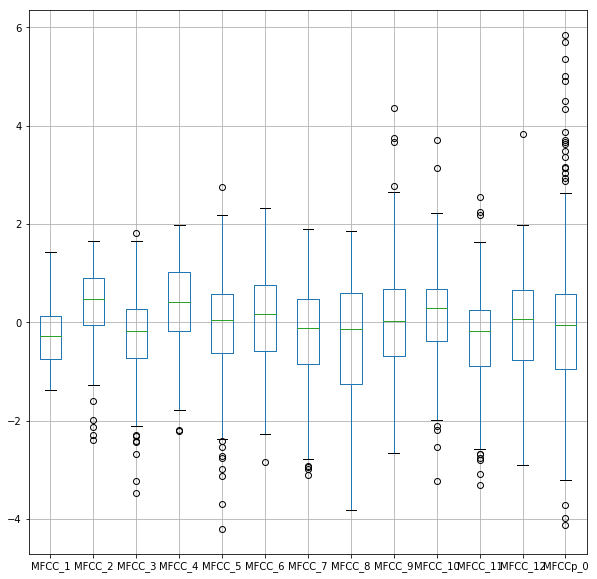

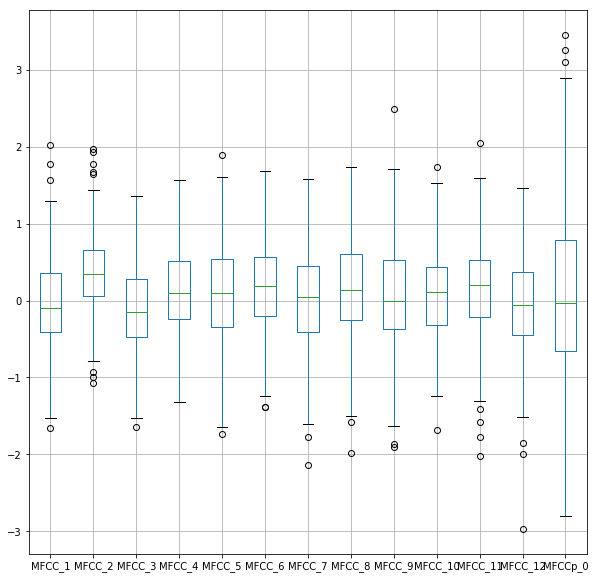

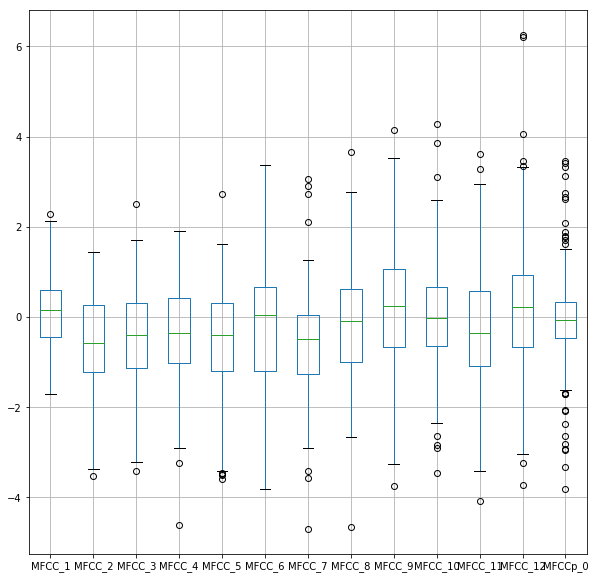

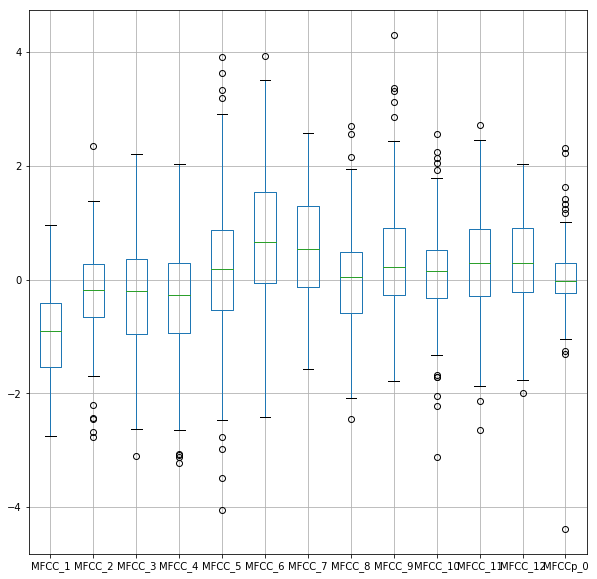

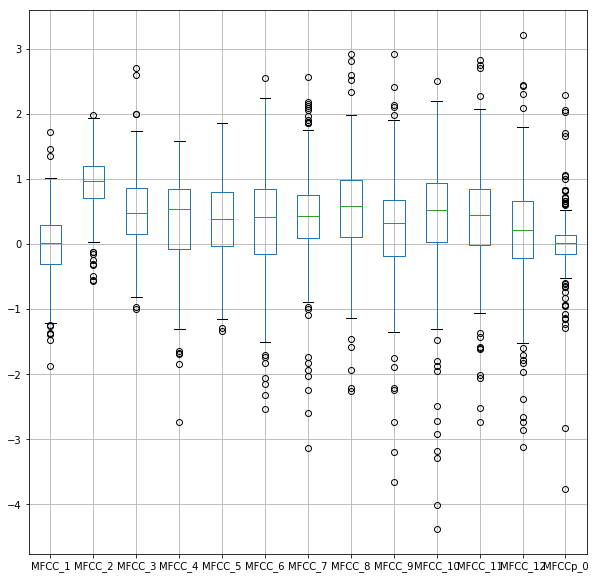

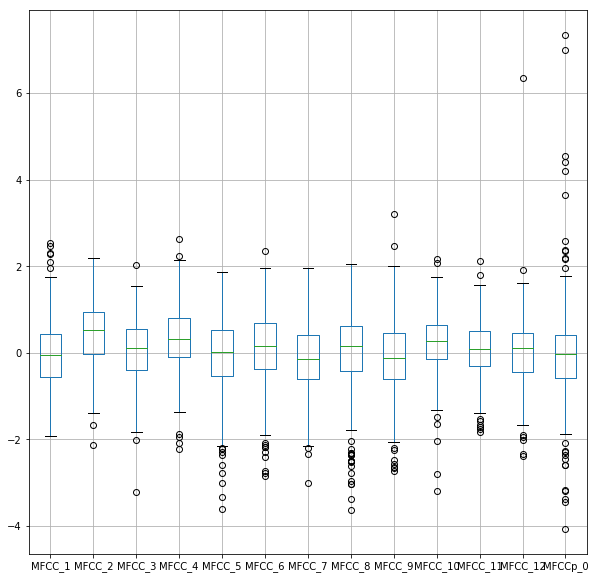

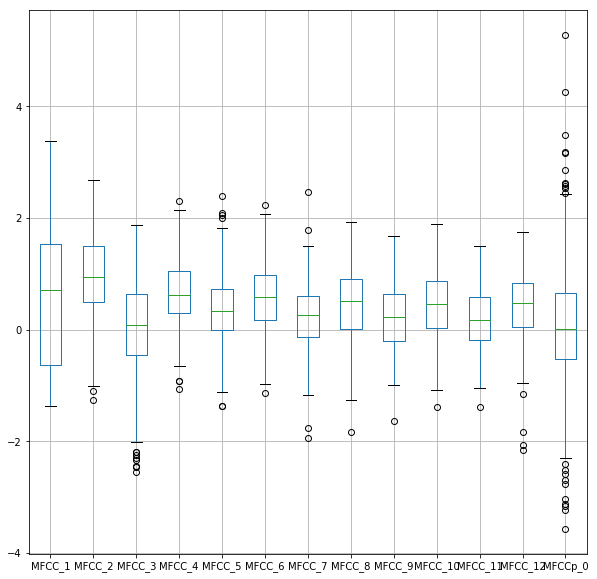

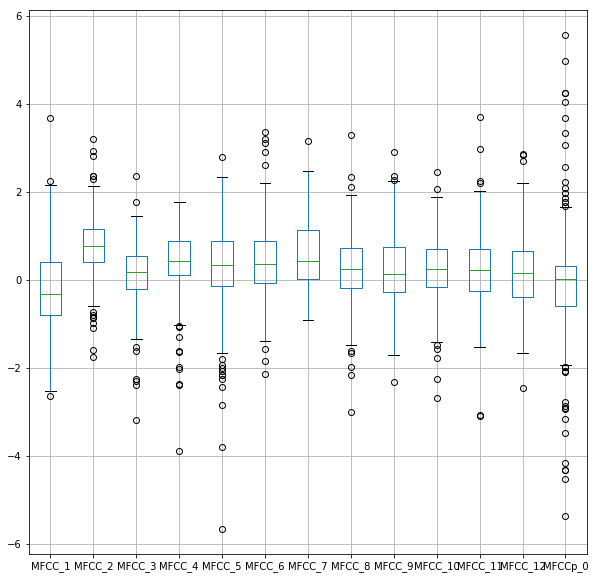

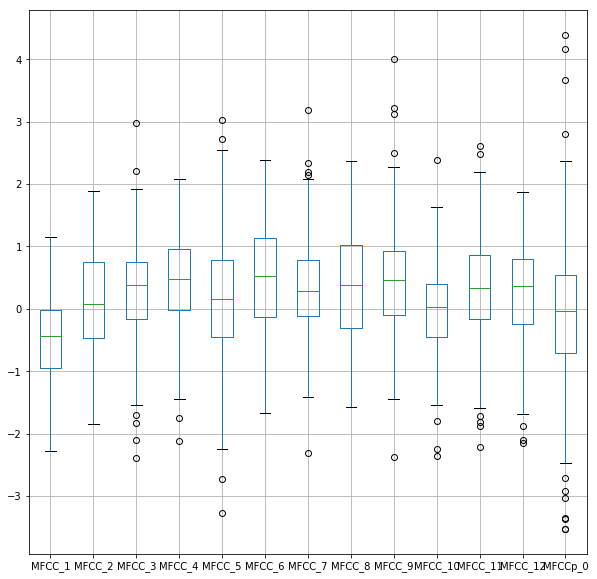

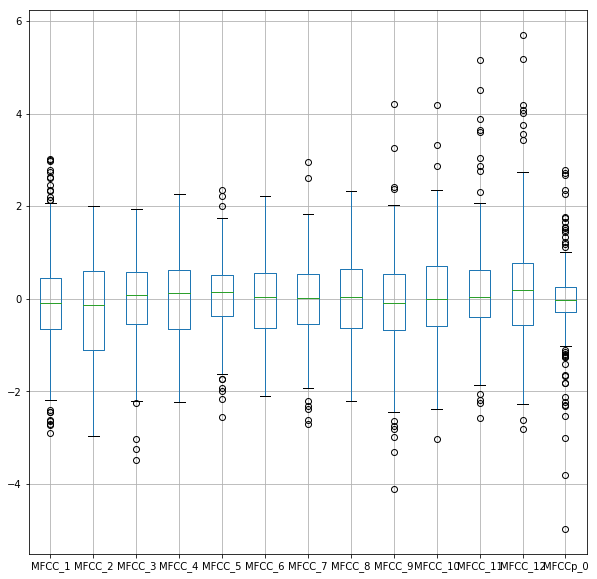

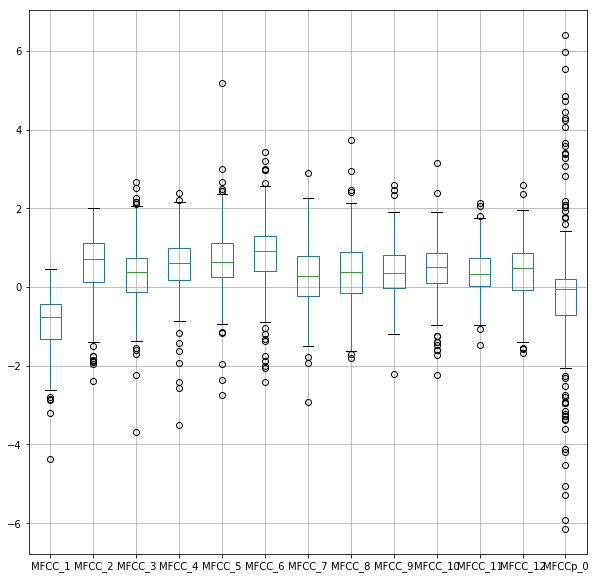

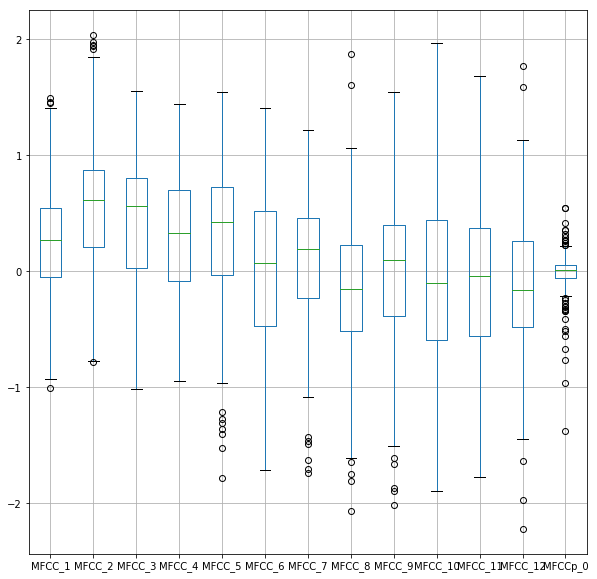

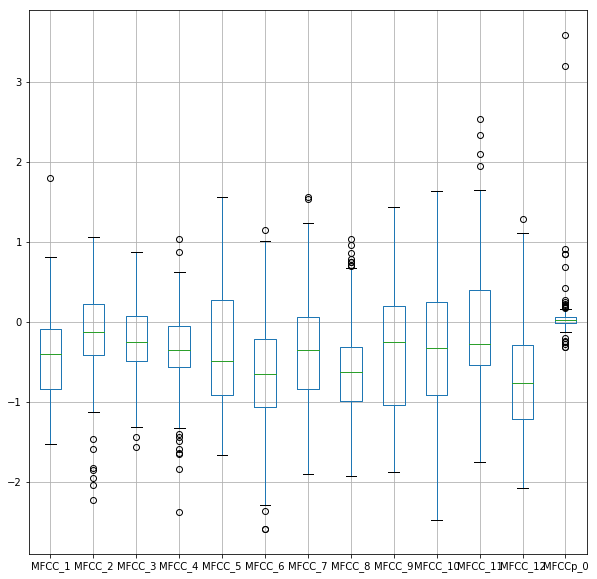

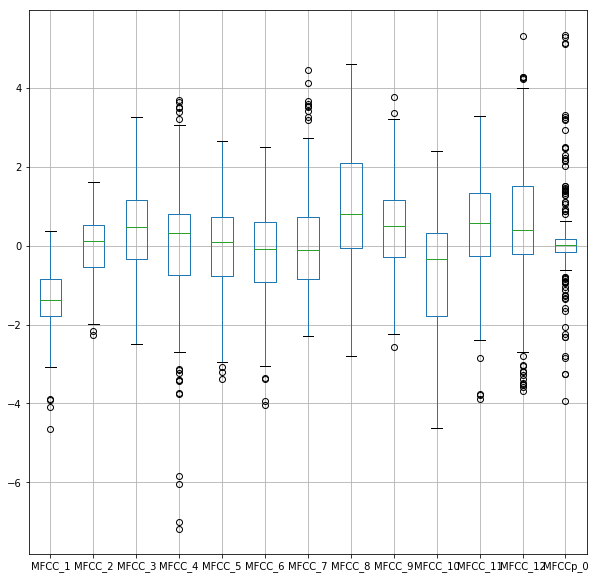

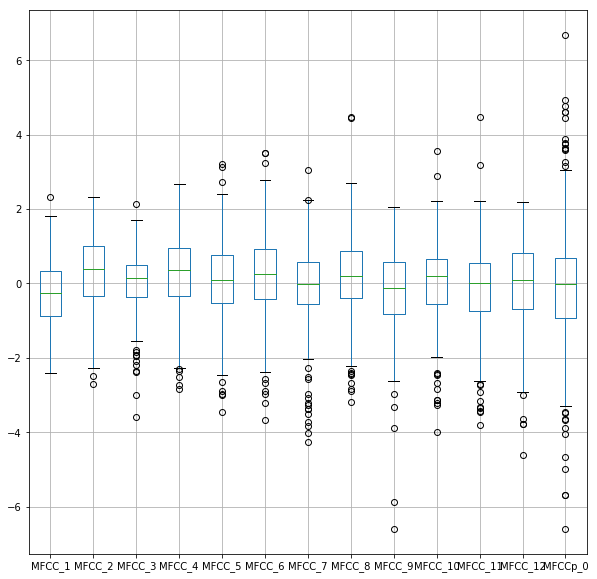

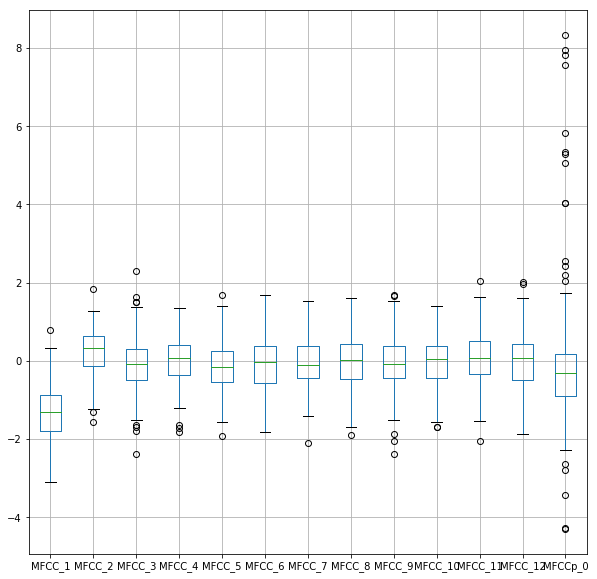

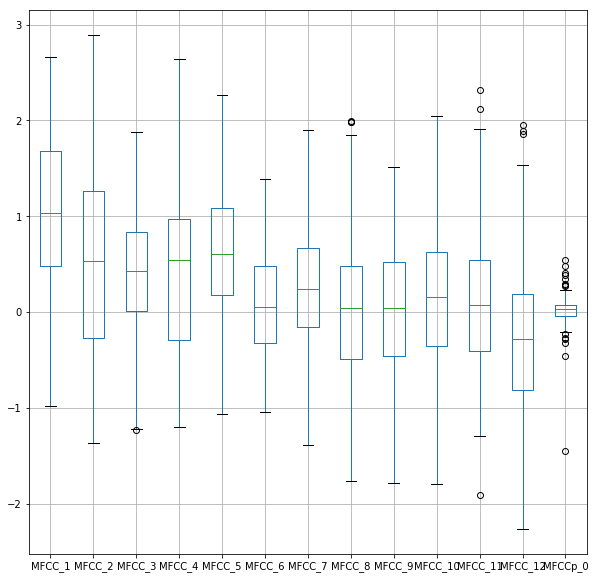

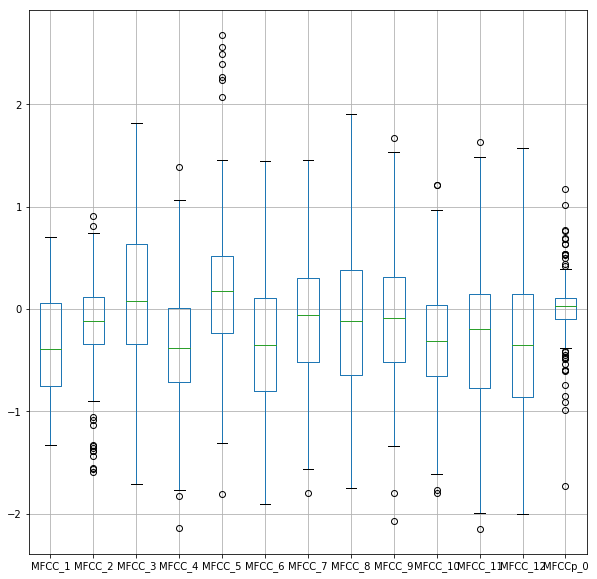

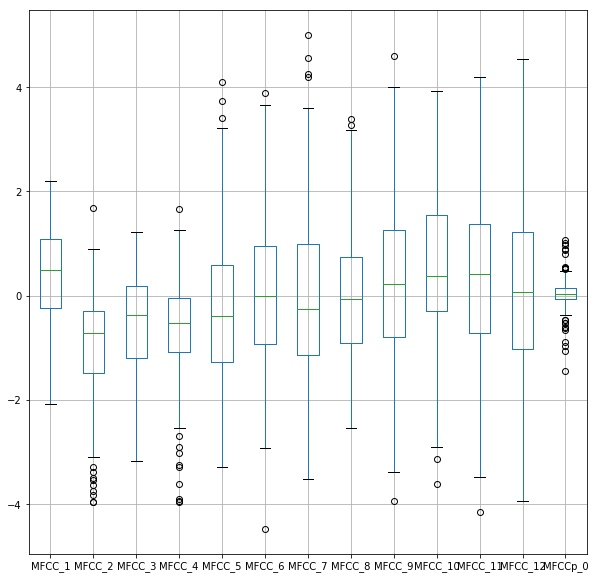

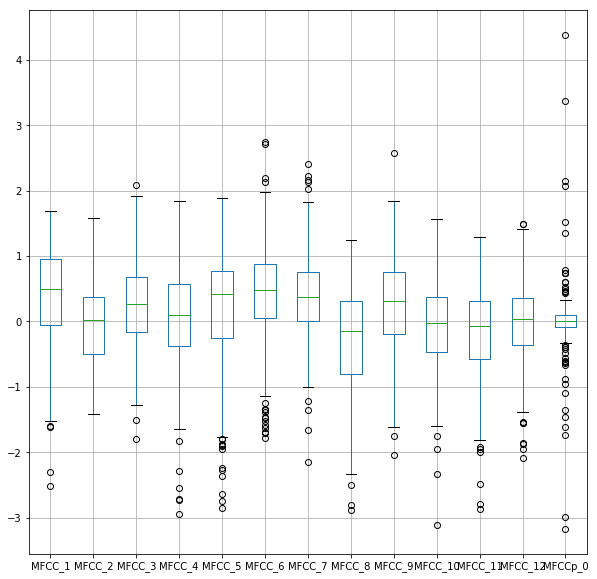

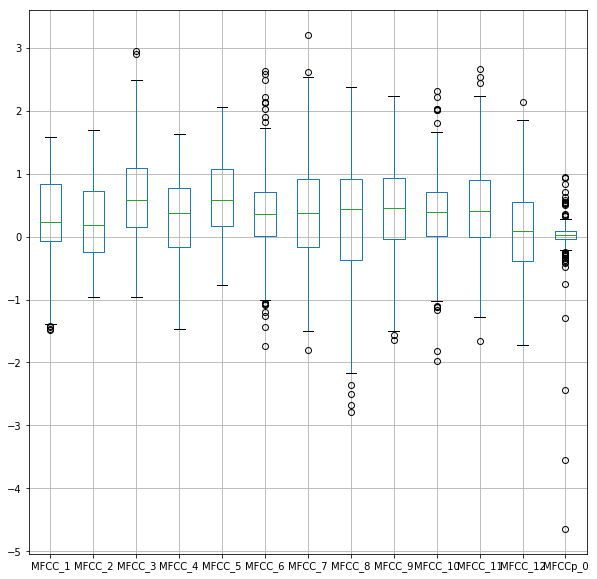

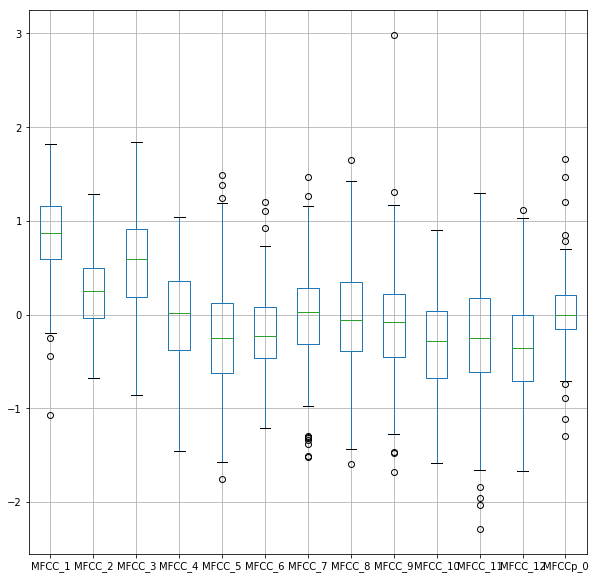

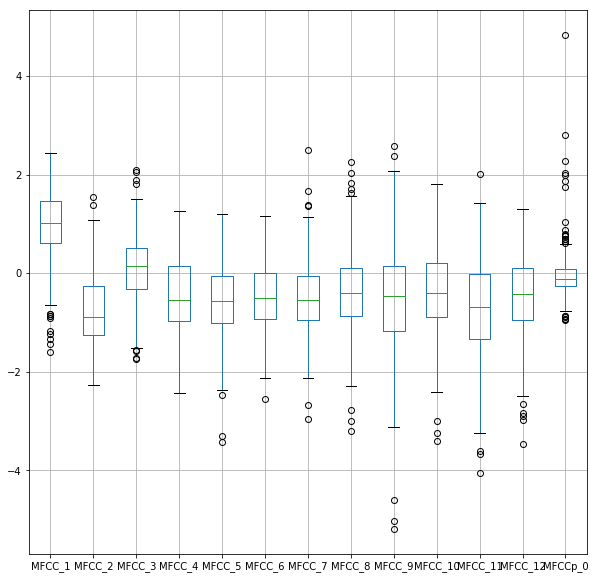

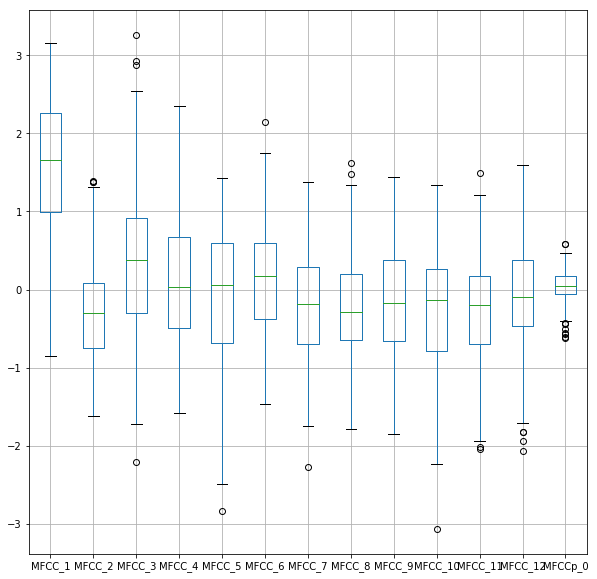

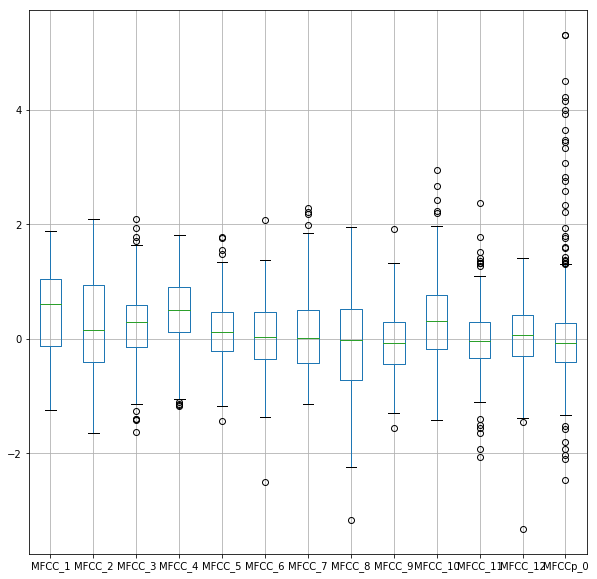

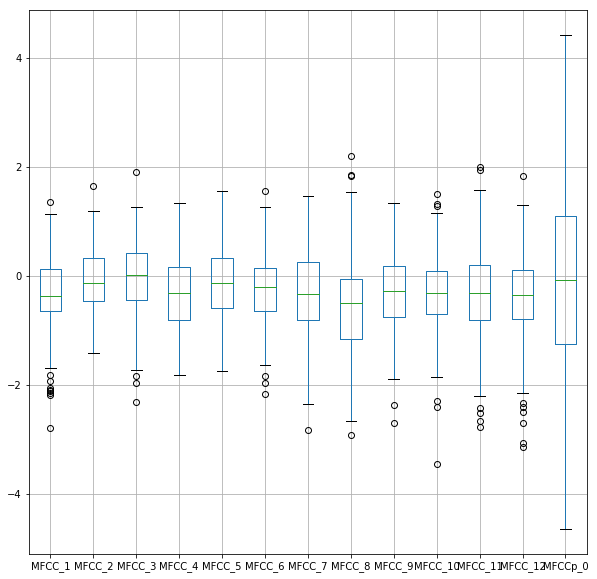

In [35]:
for i in range(0, 50):
    plt.figure(figsize=(10,10))
    (c_data[c_data.target == i])[c_data.columns[0:13]].sample(200).boxplot()
    plt.show()

Distribution over the combined hierarchical 5 classes

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
hl_shallow = {}
for i in range(0,5):
    start_i = i * 10
    end_i = ((i + 1) * 10) - 1
    clas = KerasClassifier(build_fn=snn_clas.create_baseline, epochs=20, batch_size=128, verbose=1)
    clas.fit(train_X, train_y.between(start_i,end_i))
    clas.score(test_X, test_y.between(start_i,end_i))
    hl_shallow[h_classes[i]] = clas

# Low-Level Deep Net

In [ ]:
import dnn_classifier as dnn_clas
hl_deep
for i in range(0,5):
    start_i = i * 10
    end_i = ((i + 1) * 10) - 1
    tmp = train_y.between(start_i, end_i)
    this_train_y = train_y[tmp] - start_i
    this_train_X = train_X[tmp]
    tmp = test_y.between(start_i, end_i)
    this_test_y = test_y[tmp] - start_i
    this_test_X = test_X[tmp]
    clas = KerasClassifier(build_fn=dnn_clas.create_baseline, epochs=20, batch_size=128, verbose=1)
    clas.fit(this_train_X, this_train_y)
    clas.score(this_test_X, this_test_y)
    hl_deep[h_classes[i]] = clas

## Scoring
Here we get the log likelihood of the categories when matched with its training data

In [ ]:
for i in range(0,5):
    start_i = i * 10
    end_i = ((i + 1) * 10) - 1
    tmp = test_y.between(start_i, end_i)
    this_test_y = test_y[tmp] - start_i
    this_test_X = test_X[tmp]
    pred = list(hl_deep[h_classes[i]].predict(this_test_X))
    print(str(h_classes[i]) + ": " + 
          str(metrics.accuracy_score(this_test_y, pred)))
    
    cm = metrics.confusion_matrix(test_y[tmp], np.array(pred) + start_i)
    plot_confusion_matrix(cm, classes[start_i:end_i])
    plt.show()

## Full Evaluation
We combine the classifiers to determine overall performance

In [ ]:
res_shallow_y = [None] * 5
res_deep_y = [None] * 5
for i in range(0,5):
    res_shallow_y[i] = list(hl_shallow[h_classes[i]].predict(test_X))
    res_deep_y[i] = list(hl_deep[h_classes[i]].predict(test_X))

In [ ]:
print(res_shallow_y)

In [ ]:
print(res_deep_y)

In [ ]:
res_y = [0] * len(res_shallow_y[0])
for i in range(0, len(res_y)):
    if res_shallow_y[0][i] == 1:
        res_y[i] = res_deep_y[0][i]
    elif res_shallow_y[1][i] == 1:
        res_y[i] = res_deep_y[1][i] + 10
    elif res_shallow_y[2][i] == 1:
        res_y[i] = res_deep_y[2][i] + 20
    elif res_shallow_y[3][i] == 1:
        res_y[i] = res_deep_y[3][i] + 30
    elif res_shallow_y[4][i] == 1:
        res_y[i] = res_deep_y[4][i] + 40

In [ ]:
print(res_y)

In [ ]:
from classification_plots import plot_confusion_matrix
cm = metrics.confusion_matrix(test_y, res_y)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,25))
plot_confusion_matrix(cm, classes)

## Basic Probability of File Category
We run our classifier over the file's audio frames and use basic averages to determine the probability of it belonging to a class. (Should in future have classifier give probability scores for each category for each frame but... thats future work)

In [ ]:
print(classes)

In [ ]:
from collections import Counter
def file_probability(filename, clas, preprocessor, class_list):
    test_file = pd.DataFrame(preprocessor.preprocess(filename))
    predictions = [class_list[i] for i in list(clas.predict(test_file))]
    sns.countplot(predictions)
    c = Counter(predictions)
    return [(i, c[i] / len(predictions) * 100.0) for i, count in c.most_common()]

In [ ]:
plt.figure(figsize=(10,10))
file = dataset.filename.sample(n=1).values[0]
file_probability(file, clas, preprocess, classes)

In [ ]:
dataset[dataset.filename == file]